In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#engine.execute('SELECT * FROM measurement').fetchall()

# Exploratory Climate Analysis

In [11]:
#check out data for measurement
first_row_m = session.query(Measurement).first()
first_row_m.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11bee94d0>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'tobs': 65.0,
 'id': 1}

In [12]:
#check out data for station
first_row_s = session.query(Station).first()
first_row_s.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11bef4650>,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'id': 1,
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168}

In [13]:
#find last date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)


('2017-08-23',)


In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


In [15]:
# Calculate the date 1 year ago from the last data point in the databases 
#timedelta
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=+365)
print("Query Date: ", query_date)




Query Date:  2016-08-23


In [16]:
# Perform a query to retrieve the data and precipitation scores
precip = [Measurement.date, Measurement.prcp]
precip_year= session.query(*precip).\
filter(Measurement.station == 'USC00519281').\
filter(Measurement.date >= query_date).all()
        
len(precip_year)

352

In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
rainfall=pd.DataFrame(precip_year, columns = ['Date', 'Rainfall'])
#.set_index("Date")
rainfall.head()

,Date,Rainfall
0,2016-08-23,1.79
1,2016-08-24,2.15
2,2016-08-25,0.06
3,2016-08-26,0.01
4,2016-08-27,0.12


In [18]:
rainfall.dtypes

Date         object
Rainfall    float64
dtype: object

In [19]:
# Check date format
rainfall.Date = pd.to_datetime(rainfall['Date'], format='%Y-%m-%d %H:%M:%S.%f')
# Sort the dataframe by date
rainfall = rainfall.set_index("Date")
rainfall = rainfall.sort_index()
rainfall = rainfall.dropna()

In [20]:
rainfall.head()

,Rainfall
Date,
2016-08-23,1.79
2016-08-24,2.15
2016-08-25,0.06
2016-08-26,0.01
2016-08-27,0.12


In [21]:
len(rainfall)

352

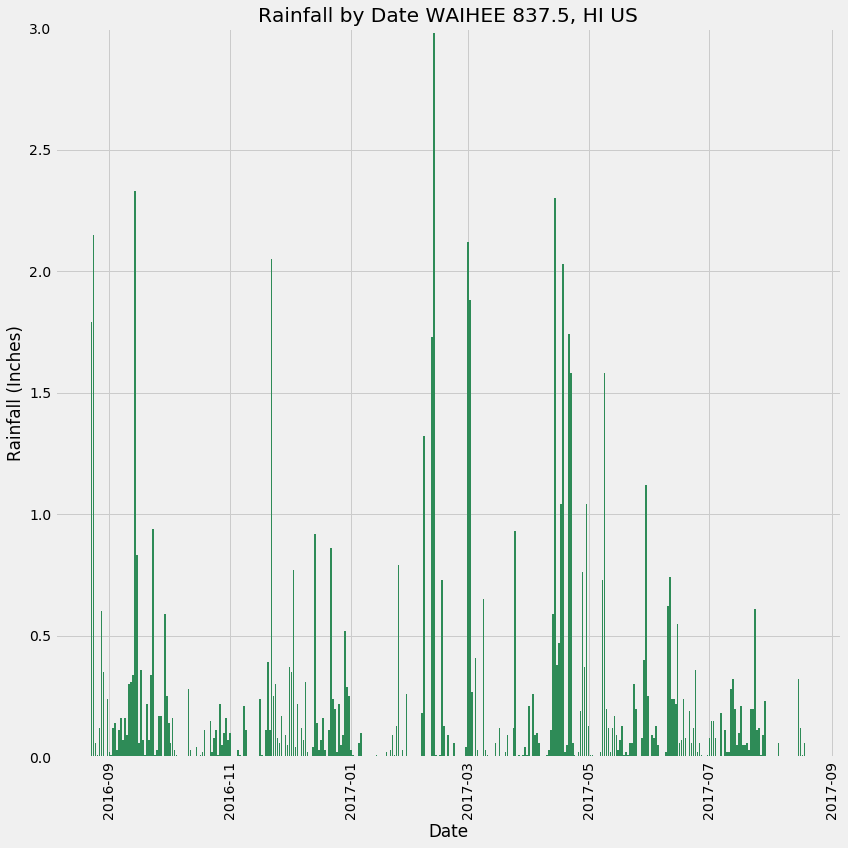

In [22]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.bar(rainfall.index.values,rainfall.Rainfall, color='seagreen')

plt.xticks(rotation=90)
plt.title("Rainfall by Date WAIHEE 837.5, HI US")
plt.xlabel("Date")
plt.ylabel("Rainfall (Inches)")
plt.ylim(0,3)
plt.tight_layout()
plt.show()


In [23]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rainfall["Rainfall"].describe()

count    352.000000
mean       0.198949
std        0.419182
min        0.000000
25%        0.000000
50%        0.060000
75%        0.190000
max        2.980000
Name: Rainfall, dtype: float64

In [24]:
#name of most active
most_active= session.query(Station.name).\
        filter(Station.station=="USC00519281").all()
most_active



[('WAIHEE 837.5, HI US')]

In [25]:
# Design a query to show how many stations are available in this dataset?
stations = [func.count(Station.station)]
number_of_stations= session.query(*stations).all()
number_of_stations

[(9)]

In [26]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = [Measurement.station, func.count(Measurement.station)]
count_stations= session.query(*station_count).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()
count_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [27]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


precip = (Measurement.tobs)
waihee_year = session.query(precip).\
filter(Measurement.station == 'USC00519281').\
filter(Measurement.date >= query_date).all()
#waihee_year





In [28]:
#dataframe
df=pd.DataFrame(waihee_year)
len(df)

352

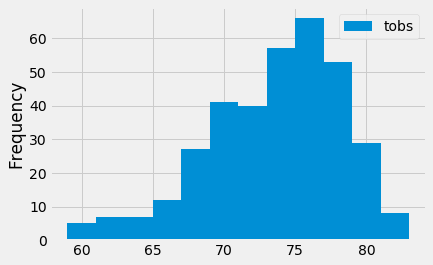

In [29]:
#histogram
df.plot.hist(bins=12)

In [30]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temps = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]
waihee_temps = session.query(*temps).filter(Measurement.station =='USC00519281').all()
waihee_temps

#precip_year= session.query(*precip).\
#filter(Measurement.station == 'USC00519281').\
#filter(Measurement.date >= query_date).all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

## Bonus Challenge Assignment

In [31]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [32]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [33]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [34]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [35]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [36]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [37]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [38]:
# Plot the daily normals as an area plot with `stacked=False`
